# Overview

In [ ]:
pip install jupyter-dash dash-cytoscape -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
pd.options.mode.chained_assignment = None

from jupyter_dash import JupyterDash
import dash_cytoscape as cyto
from dash import html
from dash import dcc
from dash.dependencies import Output, Input
import plotly.express as px
import math
from dash import no_update

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Phân tích và trực quan DL/raw_data.csv')
df.head()

,Giá,Diện tích,Phòng ngủ,Loại,Hướng,Tầng,Toilet,Đường trước nhà,Phòng khách,Pháp lý,Vị trí,Thông tin,Mô tả
0,700 triệu,60m2,NaN,Bán nhà riêng,NaN,NaN,NaN,NaN,NaN,NaN,"10.8839675,106.5870611",Mã tài sản: 22102157608 / Cập nhật: 18-10-2022,"\nBán căn nhà 1 lầu đường Nguyễn Văn Bứa, Hóc ..."
1,63 triệu /m2,250m2,NaN,Đất nền - Đất ở - Đất thổ cư,Đông Bắc,NaN,NaN,10m - 15m,NaN,Sổ hồng,"10.707568384413616,106.7071383618691",Mã tài sản: 22102156387 / Cập nhật: 18-10-2022,\nBán nhiều lô đất thái sơn 1 bộ quốc phòng 10...
2,680 triệu,80m2,2 PN,Bán nhà riêng,NaN,1 tầng,2.0,8m,1.0,Sổ hồng,"10.842114691706804,106.59722456931152",Mã tài sản: 22102152324 / Cập nhật: 18-10-2022,\n 4x 20m vuông vức 80...
3,670 triệu,84m2,2 PN,Bán nhà riêng,NaN,2 tầng,2.0,6m,1.0,Sổ hồng,"10.8479835,106.5866452",Mã tài sản: 22102156181 / Cập nhật: 18-10-2022,\n tôi bán nhà 1 trệt ...
4,"7,000/m2",90m2,2 PN,Bán nhà phố,NaN,NaN,2.0,NaN,1.0,Hợp đồng,"10.781366413891242,106.72031374601438",Mã tài sản: 22102152084 / Cập nhật: 17-10-2022,\nTỔNG QUAN DỰ ÁN \n\n- Tổng diện tích đất: 9....


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8594 entries, 0 to 8593
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Giá              8594 non-null   object 
 1   Diện tích        8028 non-null   object 
 2   Phòng ngủ        4150 non-null   object 
 3   Loại             8591 non-null   object 
 4   Hướng            1616 non-null   object 
 5   Tầng             3824 non-null   object 
 6   Toilet           4026 non-null   float64
 7   Đường trước nhà  4971 non-null   object 
 8   Phòng khách      3201 non-null   float64
 9   Pháp lý          6389 non-null   object 
 10  Vị trí           8592 non-null   object 
 11  Thông tin        8594 non-null   object 
 12  Mô tả            8594 non-null   object 
dtypes: float64(2), object(11)
memory usage: 873.0+ KB


# 1. Tiền xử lý dữ liệu

In [ ]:
df.drop_duplicates(subset=['Mô tả'], inplace=True)

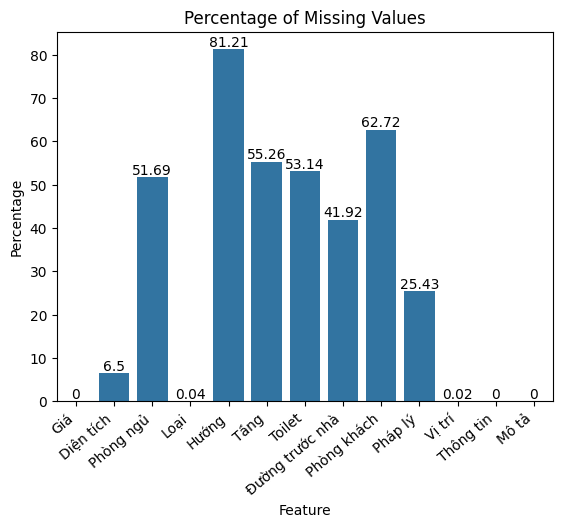

In [ ]:
null_percentage = round(df.isnull().mean() * 100,2)
ax = sns.barplot(x=null_percentage.index, y=null_percentage)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.bar_label(ax.containers[0]);
ax.set_xlabel('Feature')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Missing Values')
plt.show()

Có thể thấy các thuộc tính như giá (target), loại, vị trí, thông tin, mô tả gần như không tồn tại missing values. Còn các thuộc tính còn lại có tỉ lệ missing values khá lớn.

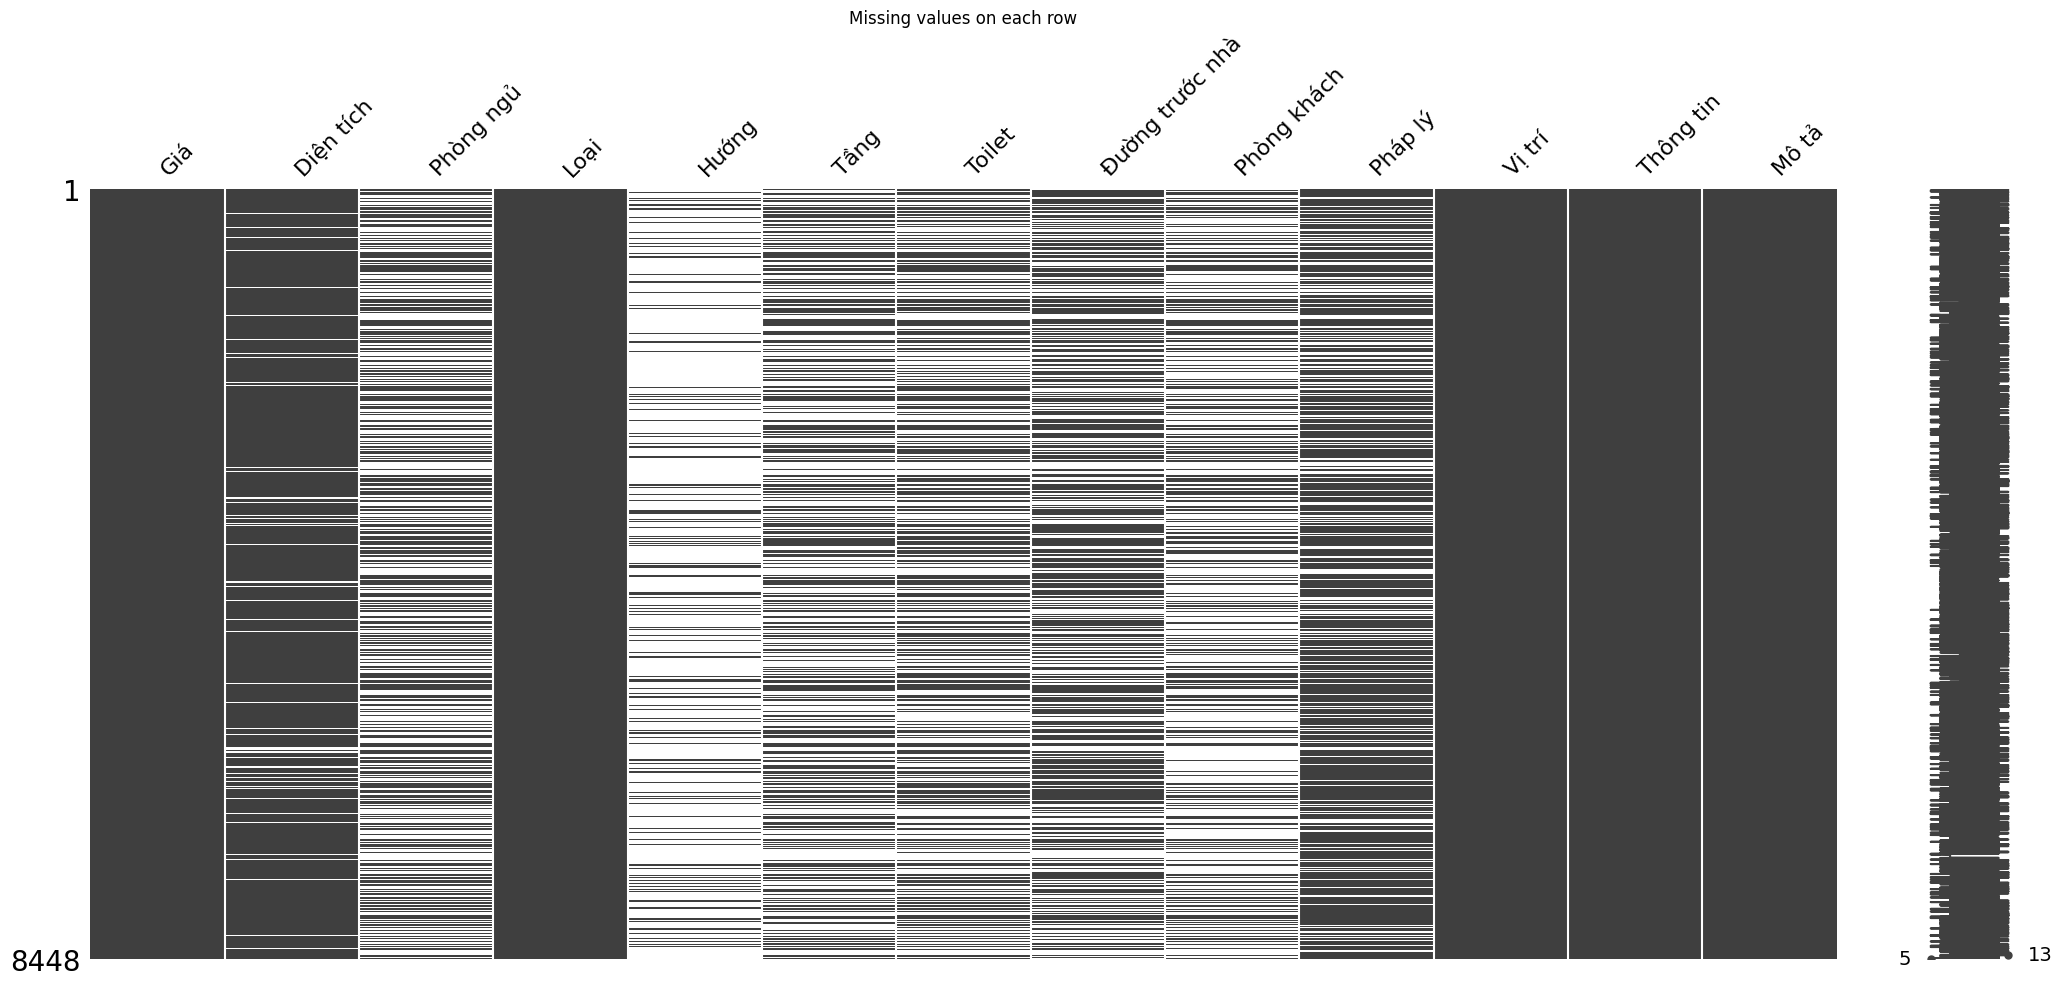

<Figure size 1500x900 with 0 Axes>

In [ ]:
import missingno as msno
ax = msno.matrix(df)
ax.set_title("Missing values on each row")
plt.figure(figsize = (15,9))
plt.show()

<Axes: >

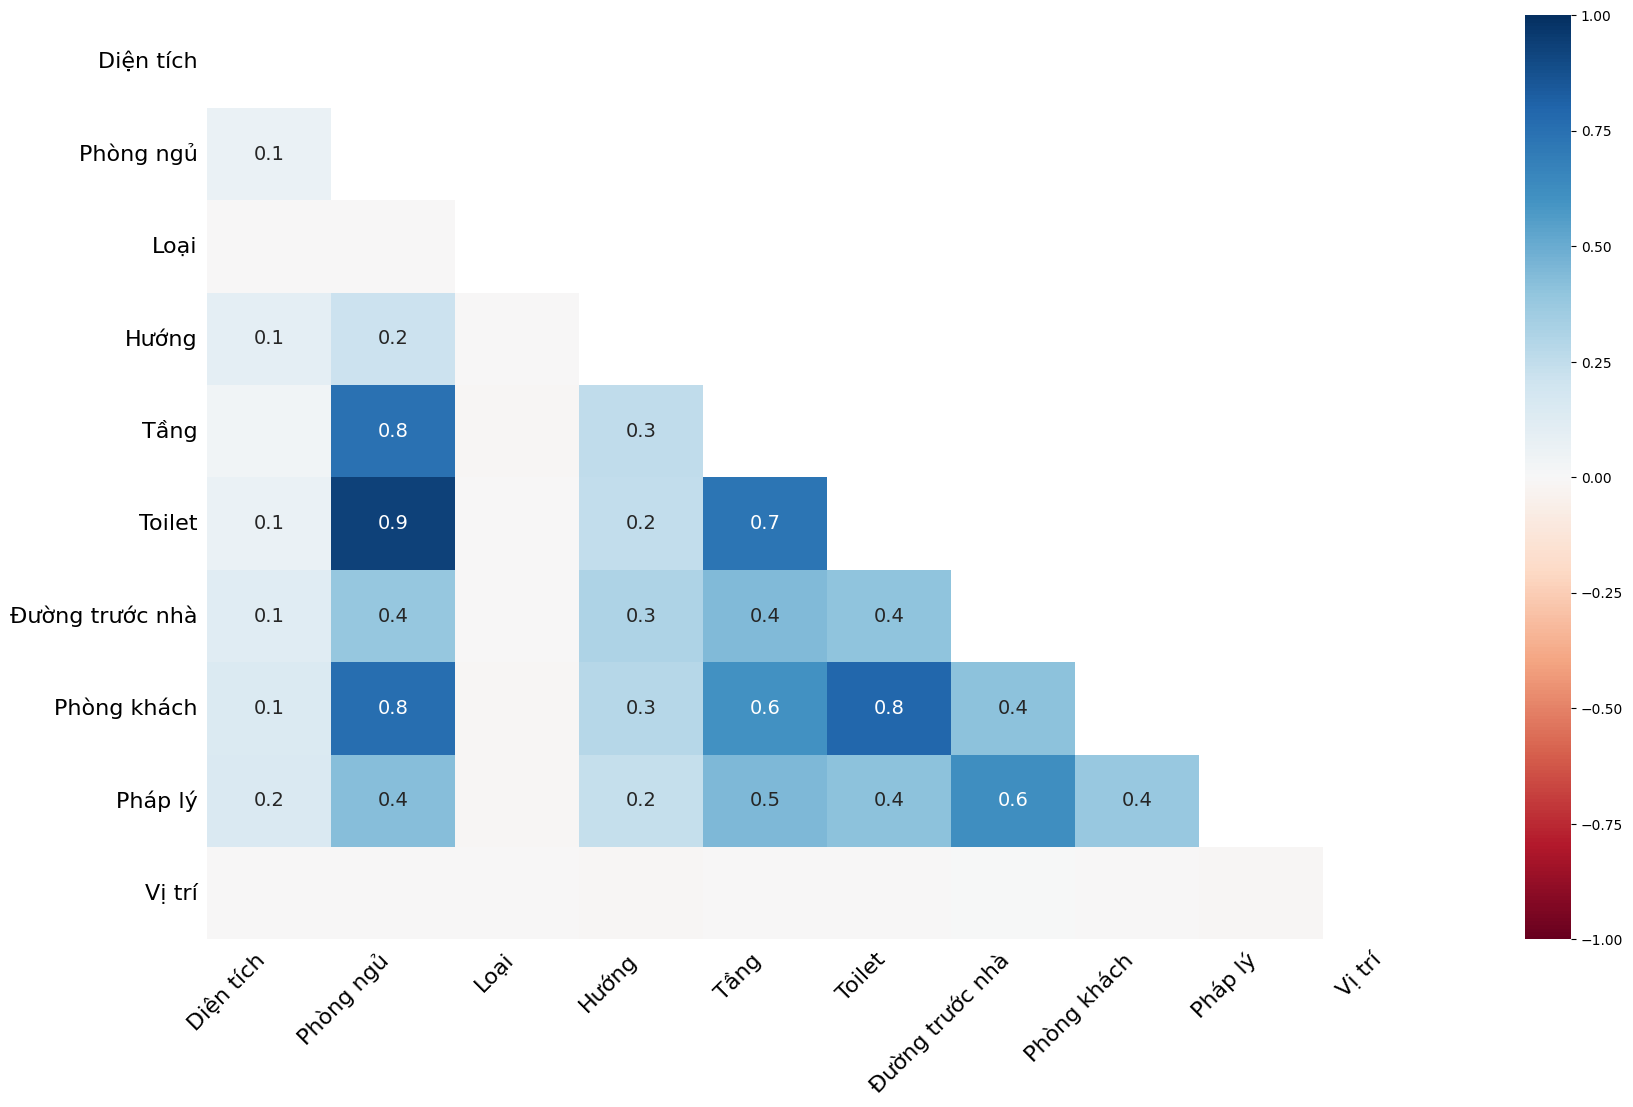

In [ ]:
msno.heatmap(df, labels = True)

Correlation heatmap ở trên biểu diễn tương quan của các thuộc tính thông qua missing values. Tương quan này được xác định khi một cột có giá trị null thì cột còn lại có giá trị null hay không

Nullity correlation thuộc khoảng (-1, 1)

- -1 Nghĩa là khi một cột (feature) có giá trị khác null, cột còn lại sẽ có giá trị null
- 0 Nghĩa là không có sự tương quan giữa 2 cột (feature)
- 1 Nghĩa là khi một cột (feature) có giá trị khác null, cột còn lại cũng có giá trị khác null và ngược lại.

Không giống như các heatmap khác, null correlation heatmap có khá nhiều cột không chứa giá trị (màu trắng), đây là những cột gần như null hoặc gần như không có missing value. Những cột này sẽ được heatmap loại bỏ vì không đem lại thông tin có giá trị

Ví dụ như biến phòng ngủ và toilet có null correlation rất cao (0.9), nghĩa là khi biến phòng ngủ bị bỏ trống thì biến toilet cũng bị bỏ trống. Vì vậy, nếu xác định xóa giá trị null trên biến phòng ngủ thì cũng nên xóa các dòng tương ứng trong biến toilet.

In [ ]:
object_cols = df.select_dtypes(include='object')
for col in object_cols.columns:
  df[col] = df[col].str.lower()
  df[col] = df[col].str.replace('\n','')
  df[col] =df[col].str.strip()

In [ ]:
df.dropna(subset=['Loại', 'Vị trí'], inplace=True)

In [ ]:
df['Diện tích'] = df['Diện tích'].str.replace(',', '.').str[:-2].astype(float)
df['Diện tích'].value_counts()

80.0     400
100.0    305
60.0     235
90.0     212
50.0     148
        ... 
760.0      1
198.2      1
321.4      1
117.5      1
249.0      1
Name: Diện tích, Length: 910, dtype: int64

In [ ]:
df['Diện tích'].fillna(value=df['Diện tích'].median(), inplace=True)

In [ ]:
df = df[df['Giá'] != 'Thương lượng']

def norm_price(price, area):
  x = np.nan
  split = price.replace(',', '.').split(' ', 3)
  while len(split) < 4:
    split.append(None)
  temp1, temp2, temp3, temp4 = split

  if temp2 == 'tỷ':
    x = float(temp1) * 10 ** 9
    if temp4 == 'triệu':
      x += float(temp3) * 10 ** 6
  elif (temp2 == 'triệu' and temp3 == '/m2') or temp2 == 'triệu/m2':
    x = area * float(temp1) * 10 ** 6
  elif temp2 == 'triệu':
    x = float(temp1) * 10 ** 6

  return x

df['Giá'] = df.apply(lambda row: norm_price(row['Giá'], row['Diện tích']), axis=1)
df.dropna(subset=['Giá'], inplace=True)
df['Giá'] = df['Giá'].astype(float) / 10 ** 9

df = df[df['Giá'] >= 0.3]

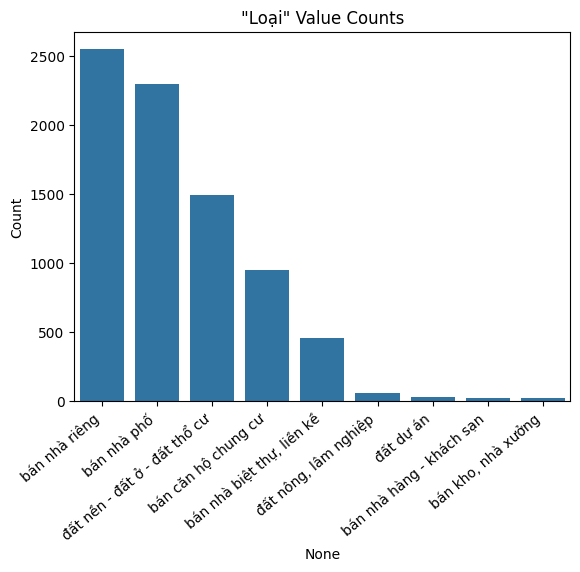

In [ ]:
cat_count = df['Loại'].value_counts()
ax = sns.barplot(x=cat_count.index, y=cat_count)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.set_ylabel('Count')
ax.set_title('"Loại" Value Counts')
plt.show()

In [ ]:
df = df[df['Loại'].apply(lambda row: row not in ['Bán nhà hàng - Khách sạn', 'Bán kho, nhà xưởng'])]

can_ho = ['Bán nhà riêng', 'Bán nhà phố', 'Bán căn hộ chung cư', 'Bán nhà biệt thự, liền kề']
df['Căn hộ'] = df['Loại'].apply(lambda row: 1 if row in can_ho else 0)

In [ ]:
df['Phòng ngủ'] = df['Phòng ngủ'].str.split().str[0]
df['Tầng'] = df['Tầng'].str.split().str[0]

for i in ['Phòng ngủ', 'Tầng', 'Toilet', 'Phòng khách']:
  df[i] = df.apply(lambda row: row[i] if not pd.isna(row[i]) else (1 if row['Căn hộ'] == 1 else 0), axis=1)
  df[i] = df[i].astype(int)

In [ ]:
df[['temp1', 'temp2']] = df['Đường trước nhà'].str.replace('m', '').str.replace('>', '').str.split(' - ', expand=True)
df['Đường trước nhà'] = df.apply(lambda row: 0 if pd.isna(row['Đường trước nhà']) else
                                 (row['temp1'] if pd.isna(row['temp2']) else np.mean([int(row['temp1']), int(row['temp2'])])), axis=1)
df['Đường trước nhà'] = df['Đường trước nhà'].astype(float)

In [ ]:
df['Vị trí'].value_counts()

10.876248,106.660338      679
10.8019128,106.7647475     90
10.7756587,106.7004238     85
10.8103172,106.7309796     49
10.7745965,106.6679542     49
                         ... 
10.8602356,106.7568433      1
10.7161241,106.7400117      1
10.7927909,106.6839011      1
10.6425712,106.6438673      1
10.7854876,106.6470047      1
Name: Vị trí, Length: 2823, dtype: int64

In [ ]:
df[['Vĩ độ', 'Kinh độ']] = df['Vị trí'].str.split(',', expand=True).astype(float)

In [ ]:
geolocator = Nominatim(user_agent='geoapiExercises')

def get_district(locator, lat, long):
  location = locator.reverse(str(lat) + ',' + str(long)).raw['address']
  return location.get('city_district', location.get('district', location.get('city', np.nan)))

df['Quận/Huyện'] = df.apply(lambda row: get_district(geolocator, row['Vĩ độ'], row['Kinh độ']), axis=1)
df.dropna(subset=['Quận/Huyện'], inplace=True)

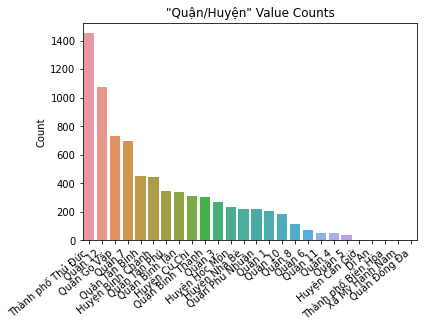

In [ ]:
district_count = df['Quận/Huyện'].value_counts()
ax = sns.barplot(x=district_count.index, y=district_count)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.set_ylabel('Count')
ax.set_title('"Quận/Huyện" Value Counts')
plt.show()

In [ ]:
df = df[~df['Quận/Huyện'].isin(['Dĩ An', 'Thành phố Biên Hòa', 'Xã Mỹ Hạnh Nam', 'Quận Đống Đa'])]

In [ ]:
df['Thông tin'] = df['Thông tin'].str.split().str[7]
df.rename(columns={'Thông tin': 'Ngày đăng'}, inplace=True)

In [ ]:
df.drop(columns=['Vị trí', 'temp1', 'temp2'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.to_csv('cleaned_data.csv', index=False)

# 2. Phân tích và trực quan dữ liệu

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Phân tích và trực quan DL/cleaned_data.csv')
df.head()

,Giá,Diện tích,Phòng ngủ,Loại,Hướng,Tầng,Toilet,Đường trước nhà,Phòng khách,Pháp lý,Ngày đăng,Mô tả,Căn hộ,Vĩ độ,Kinh độ,Quận/Huyện
0,0.70,60.0,1,Bán nhà riêng,NaN,1,1,0.0,1,NaN,18-10-2022,"Bán căn nhà 1 lầu đường Nguyễn Văn Bứa, Hóc Mô...",1,10.883968,106.587061,Huyện Hóc Môn
1,15.75,250.0,0,Đất nền - Đất ở - Đất thổ cư,Đông Bắc,0,0,12.5,0,Sổ hồng,18-10-2022,Bán nhiều lô đất thái sơn 1 bộ quốc phòng 10x2...,0,10.707568,106.707138,Huyện Nhà Bè
2,0.68,80.0,2,Bán nhà riêng,NaN,1,2,8.0,1,Sổ hồng,18-10-2022,4x 20m vuông vức 80 m2\r\nĐường trước nhà 8m x...,1,10.842115,106.597225,Huyện Hóc Môn
3,0.67,84.0,2,Bán nhà riêng,NaN,2,2,6.0,1,Sổ hồng,18-10-2022,tôi bán nhà 1 trệt 1 lầu Hóc Môn\r\nDt sd 84m2...,1,10.847983,106.586645,Huyện Hóc Môn
4,12.50,100.0,8,Bán nhà phố,NaN,3,8,0.0,1,Sổ hồng,17-10-2022,"+ Con đường chính đi Q1, Q3, sân bay\n+ Tập...",1,10.808407,106.673638,Quận Phú Nhuận


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7811 entries, 0 to 7810
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Giá              7811 non-null   float64
 1   Diện tích        7811 non-null   float64
 2   Phòng ngủ        7811 non-null   int64  
 3   Loại             7811 non-null   object 
 4   Hướng            1514 non-null   object 
 5   Tầng             7811 non-null   int64  
 6   Toilet           7811 non-null   int64  
 7   Đường trước nhà  7811 non-null   float64
 8   Phòng khách      7811 non-null   int64  
 9   Pháp lý          6017 non-null   object 
 10  Ngày đăng        7811 non-null   object 
 11  Mô tả            7811 non-null   object 
 12  Căn hộ           7811 non-null   int64  
 13  Vĩ độ            7811 non-null   float64
 14  Kinh độ          7811 non-null   float64
 15  Quận/Huyện       7811 non-null   object 
dtypes: float64(5), int64(5), object(6)
memory usage: 976.5+ KB


## Numerical Feature

Có 2 cột chứa missing value là Hướng và Pháp lý. Cột hướng sẽ được bỏ đi do tỉ lệ missing value quá cao còn cột Pháp lý sẽ dùng giá trị mode để thay thể missing value

In [ ]:
num_cols = ['Diện tích', 'Phòng ngủ', 'Toilet', 'Tầng', 'Đường trước nhà', 'Phòng khách']

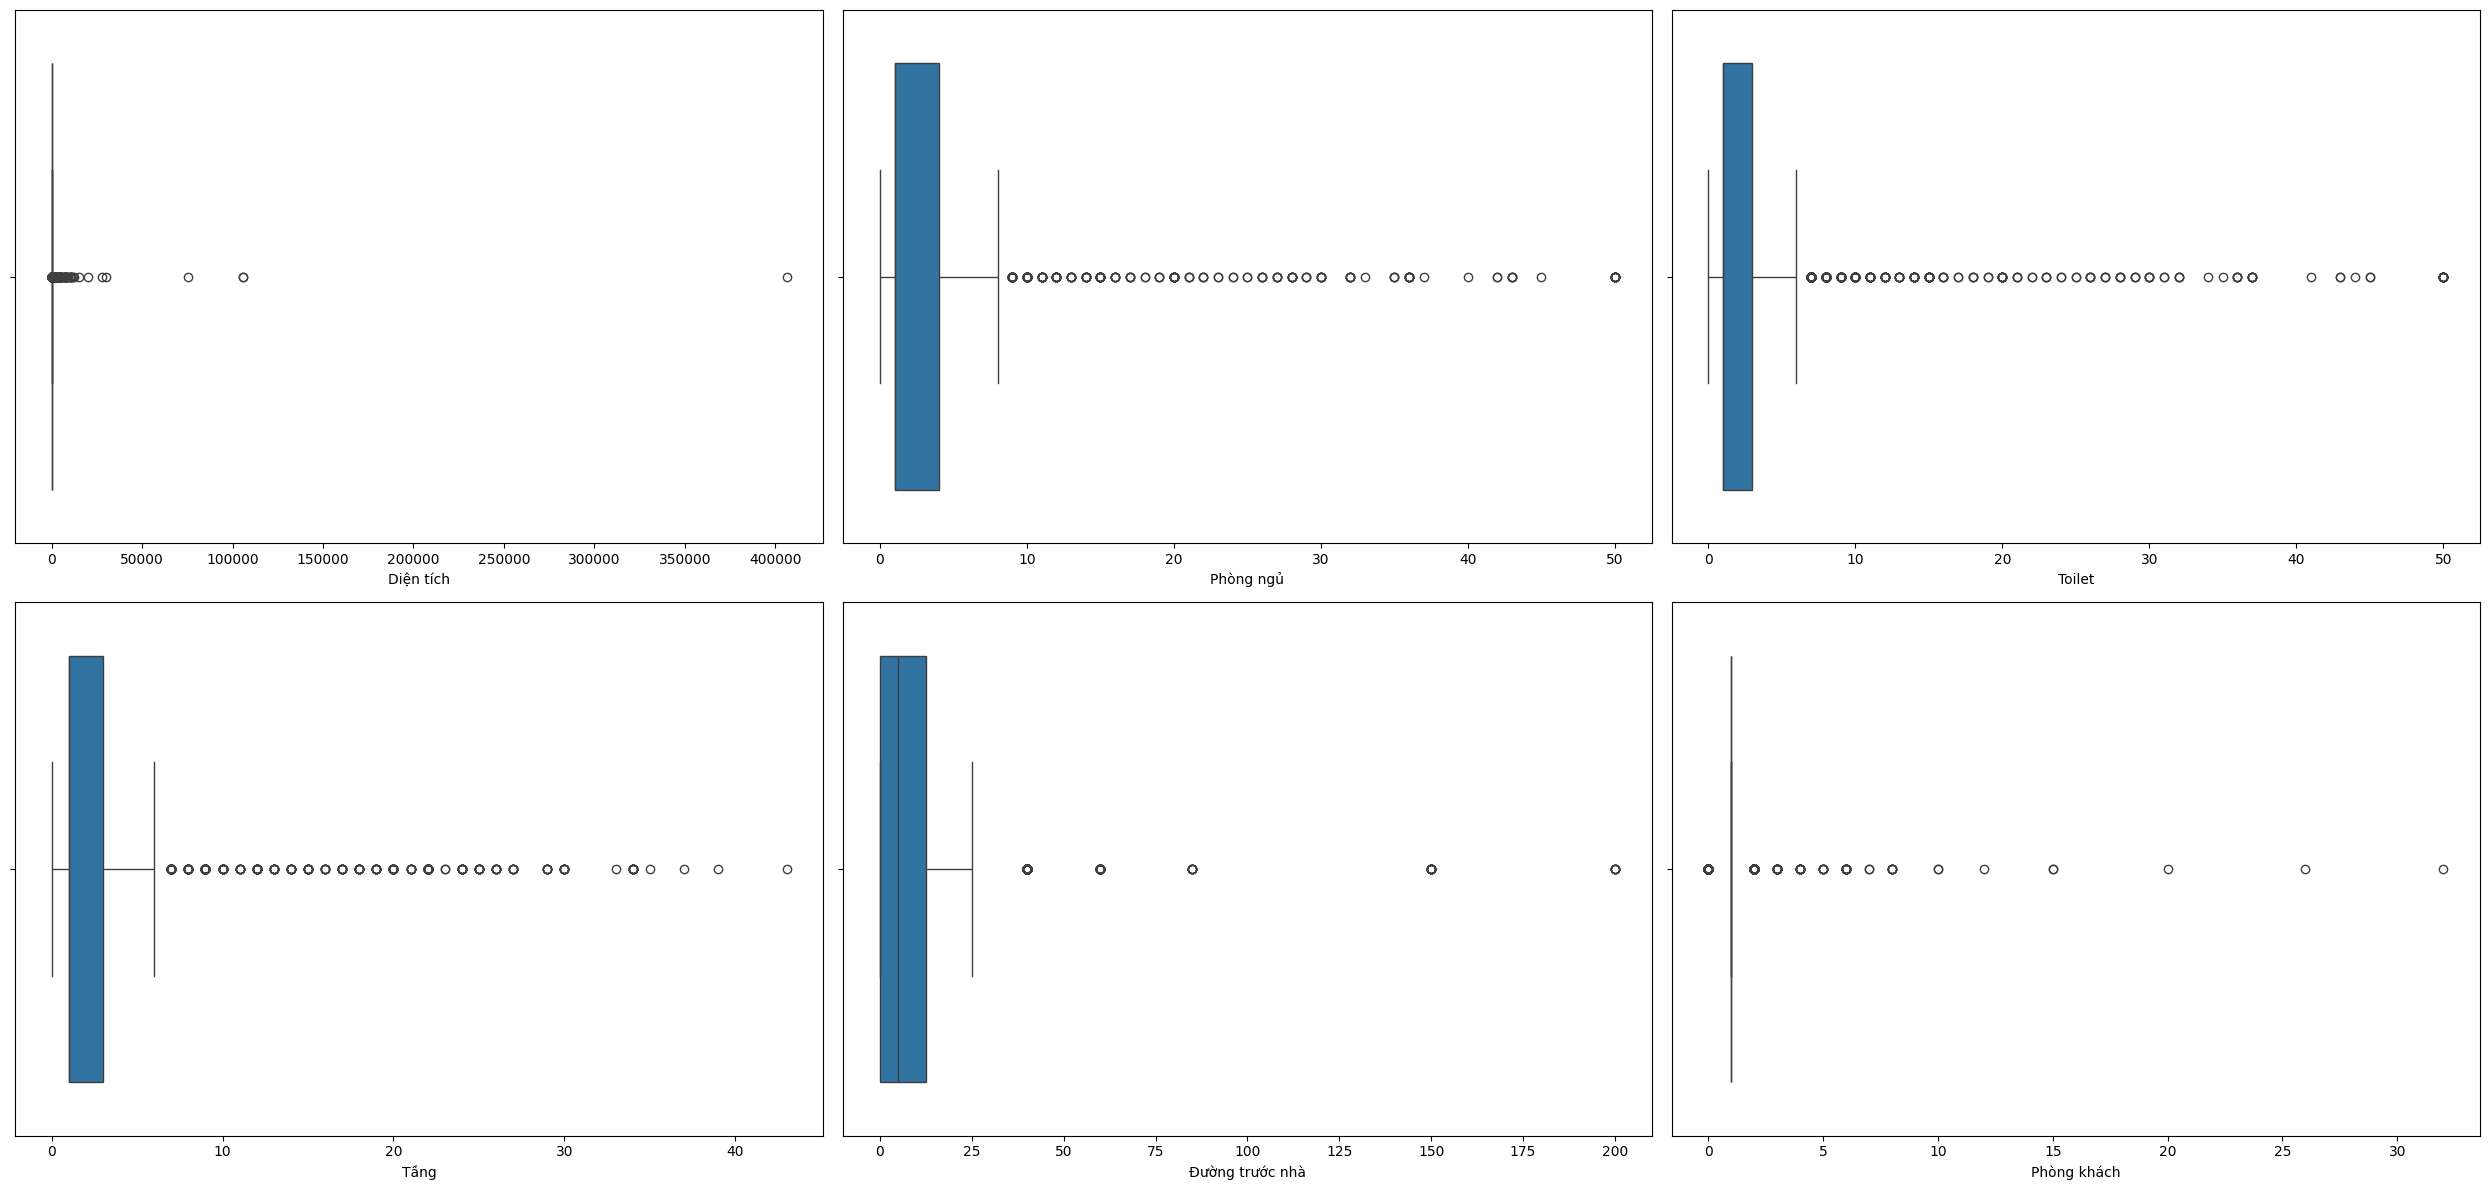

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(25, 12))
i, j = 0, -1
for col in num_cols:
  j += 1
  if j > 2:
    i, j = 1, 0
  sns.boxplot(x=df[col], ax=ax[i][j])
plt.tight_layout()
plt.show()

Dữ liệu chứa khá nhiều Outlier -> loại bỏ Outlier ở 2 cột Giá và Diện tích vì 2 cột này chứu những giá trị quá lớn và khá vô lý. Dùng IQR để loại bỏ outlier là những điểm dữ liệu nhỏ hơn Q1 và lớn hơn Q3.

In [ ]:
Q1 = df[['Giá','Diện tích']].quantile(0.1)
Q3 = df[['Giá','Diện tích']].quantile(0.9)
IQR = Q3 - Q1

df = df[~((df[['Giá','Diện tích']] < (Q1 - 1.5 * IQR)) |(df[['Giá','Diện tích']] > (Q3 + 1.5 * IQR))).any(axis=1)]

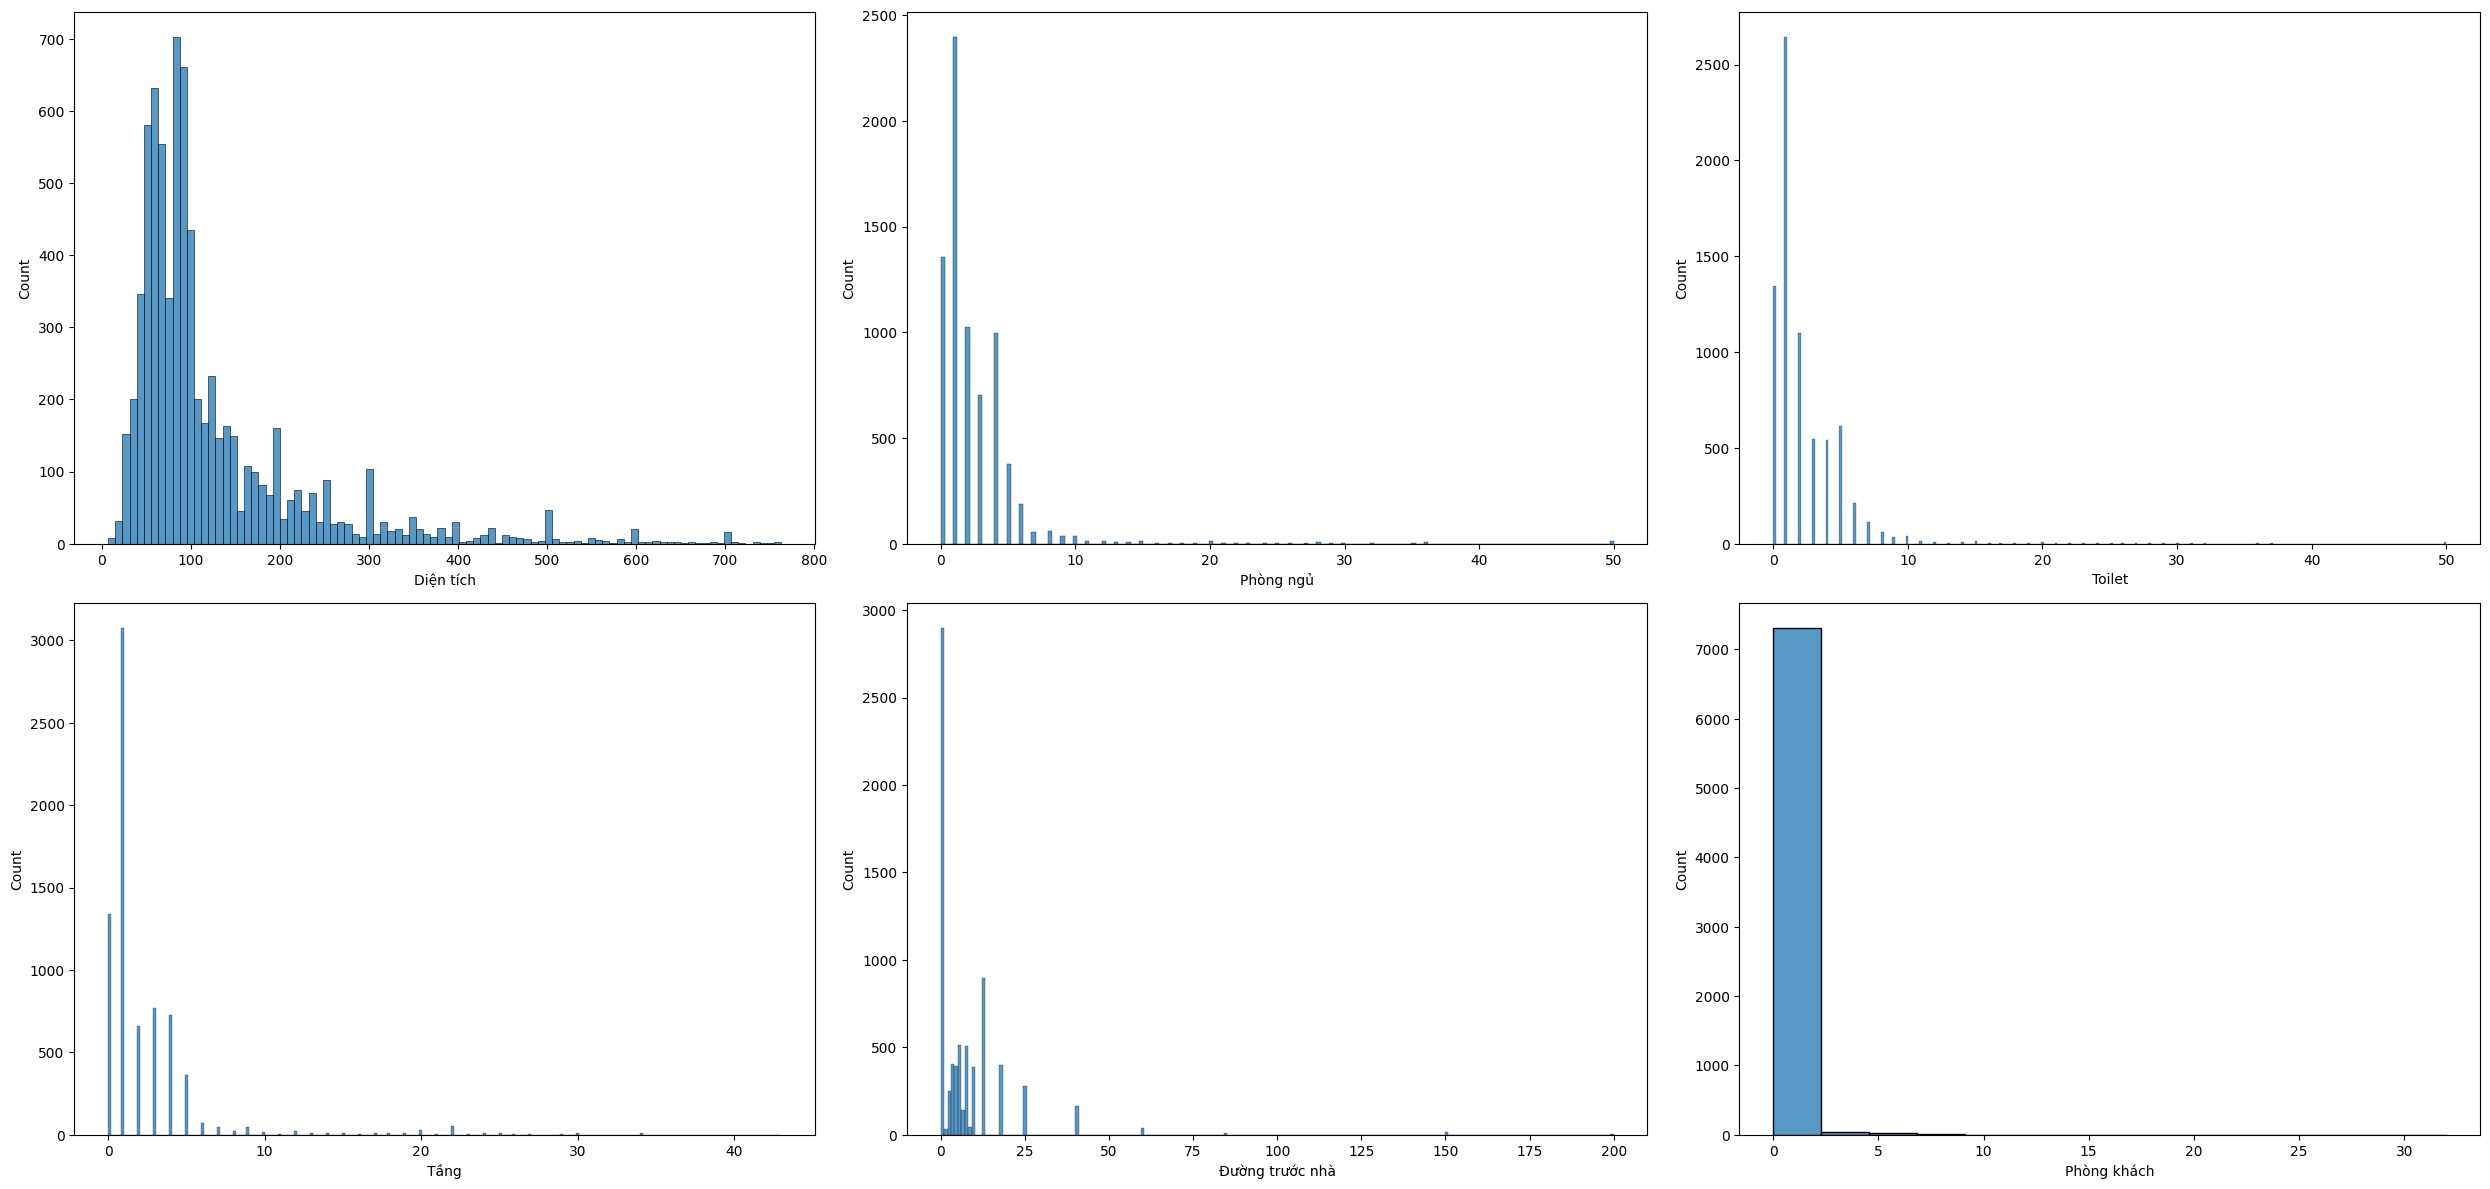

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(25, 12))
i, j = 0, -1
for col in num_cols:
  j += 1
  if j > 2:
    i, j = 1, 0
  sns.histplot(x=df[col], discrete=0, ax=ax[i][j])
plt.tight_layout()
plt.show()

Hầu hết các cột đểu lệch về phía bên trái

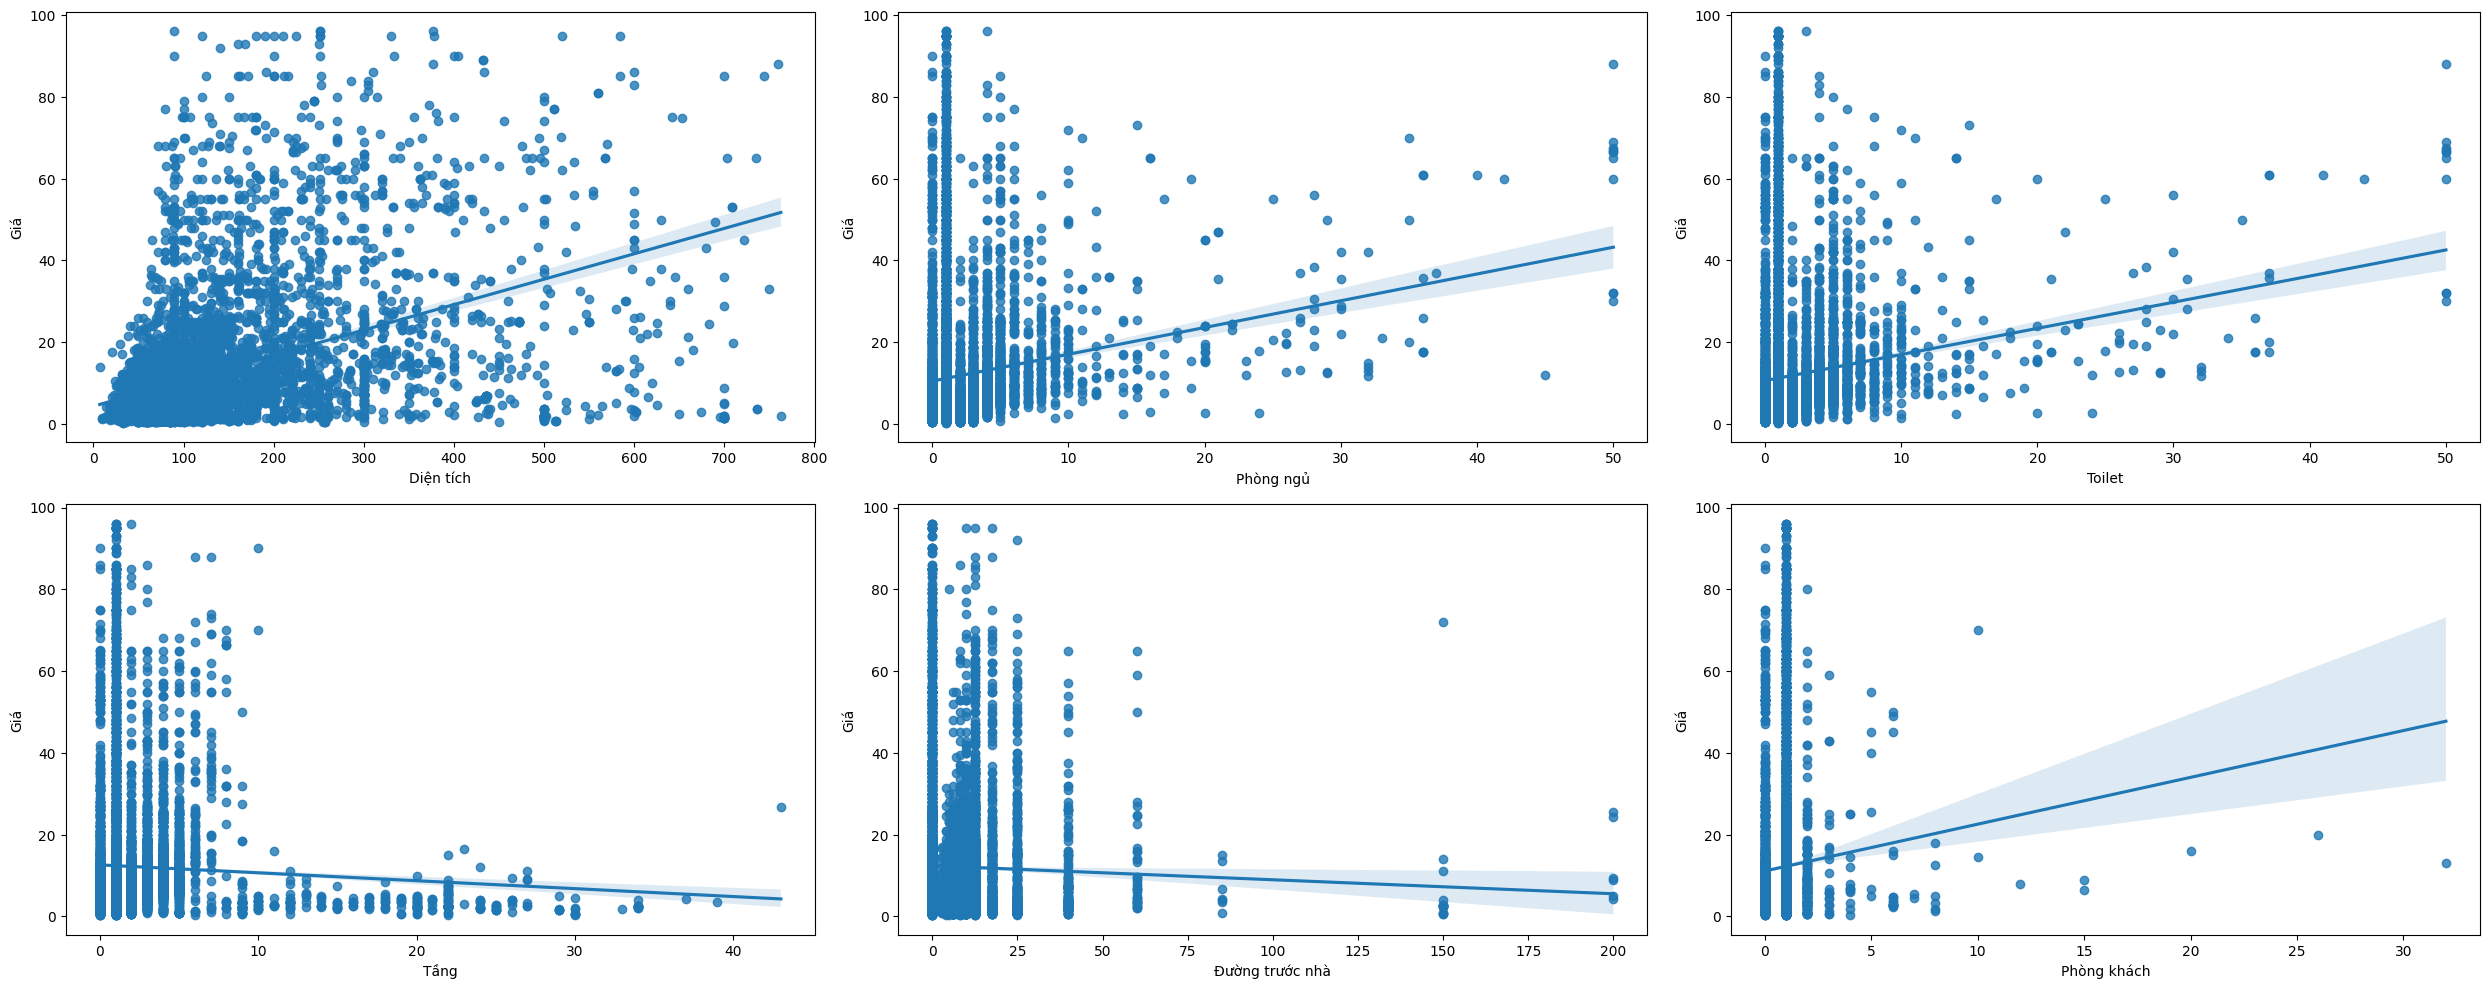

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
i, j = 0, -1
for col in num_cols:
  j += 1
  if j > 2:
    i, j = 1, 0
  sns.regplot(x=df[col], y=df['Giá'], ax=ax[i][j])
plt.tight_layout()
plt.show()

- Diện tích tương quan khá cao với giá bất động sản, có thể thấy khi diện tích tăng lên thì giá bất động sản cũng tăng lên tương ứng.
- Số lượng Phòng ngủ và Toilet cũng ảnh hưởng khá lớn đến giá bất động sản, tuy nhiên 2 yếu tố này không có độ tương quan cao như Diện tích. Nhìn vào 2 regression plot của Phòng ngủ và Toilet có thể thấy 2 thuộc tính này có sự phân tán dữ liệu khá tương đồng và đường hồi quy của 2 thuộc tính cũng khá giống nhau. Điều này cho thấy 2 thuộc tính này có sự tương quan cao với nhau.
- Một điều khá đặc biệt là khi Tầng và Đường trước nhà tăng lên thì giá nhà lại giảm xuống. Điều này có thể là do khi người bán nhập dữ liệu, người bán chỉ muốn bán 1 căn chung cư trong 1 tòa nhà nên giá trị của bất động sản chỉ là 1 căn chung cư nhưng số tầng lại là của cả tòa nhà. Và vì giá trị của 1 căn chung cư sẽ thường nhỏ hơn nhà mặt đất nên đường hồi quy mới có xu hướng đi xuống.
- Thuộc tính Phòng khách có giá trị tập trung chủ yếu trong khoảng từ 0 đến 2 nên dù đường hồi quy có xu hướng đi lên nhưng độ lỗi (error) lại rất lớn (vùng màu xanh nhạt quanh đường hồi quy) nên không thể khẳng định là Phòng khách tương quan như thế nào đối với giá bất động sản.

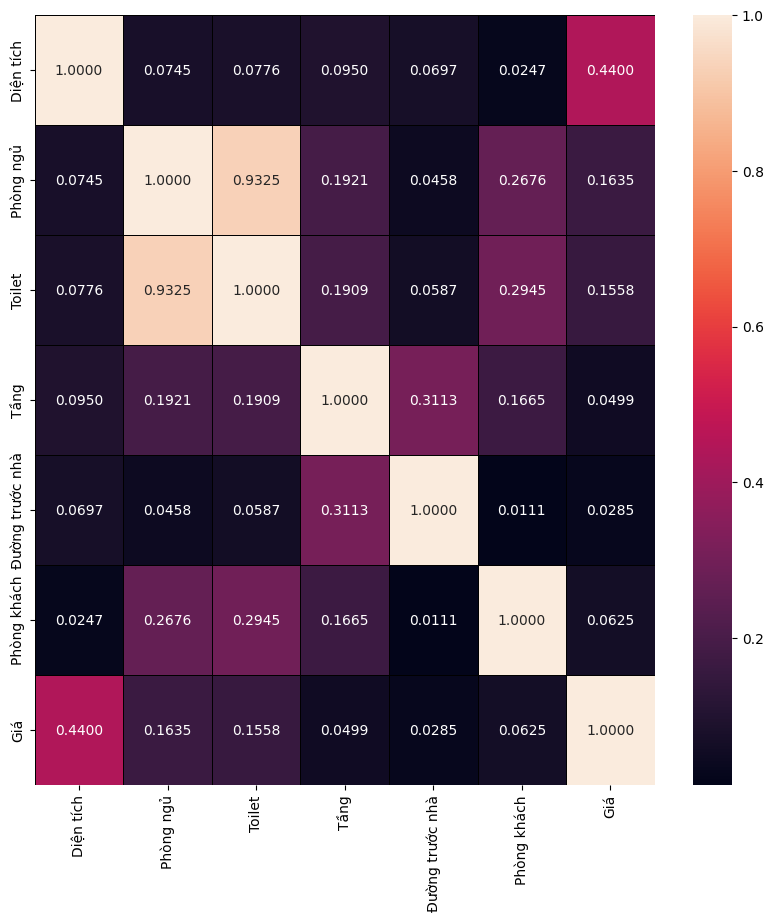

In [ ]:
df_corr = pd.concat([df[num_cols],df[['Giá']]], axis=1)
f, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_corr.corr().abs(), annot = True, linewidths = 0.5, linecolor = "black", fmt = ".4f")
plt.show()

Heat map thể hiện độ tương quan của các thuộc tính với nhau. Kết quả cho thấy Phòng ngủ và Toilet tương quan rất cao với nhau, tuy nhiên đây không phải là một điều tốt cho mô hình học máy. Hiện tượng các biến độc lập trong mô hình hồi qui phụ thuộc tuyến tính lẫn nhau gọi là đa cộng tuyến (Multicollinearity), để khắc phục hiện tượng này có thể bỏ bớt một thuộc tính (Toilet) vì trong thực tế một phòng ngủ có 1 Toilet là điều thường xuyên xảy ra.

<Axes: >

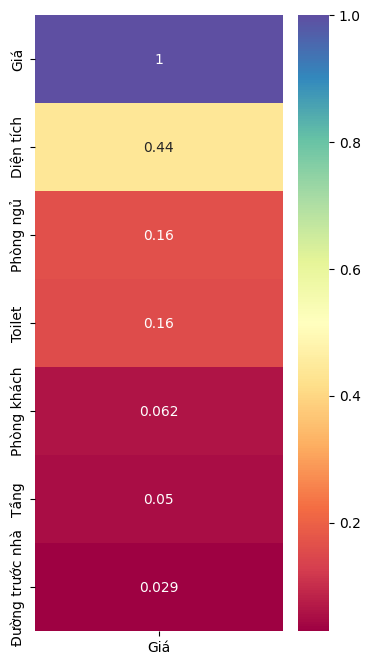

In [ ]:
cor_price=df_corr.corr().abs()[['Giá']]
plt.figure(figsize=(4,8))
sns.heatmap(cor_price.sort_values(by='Giá', ascending=False), annot=True, cmap = 'Spectral')

Diện tích có tương quan cao nhất với giá nhà và Đường trước nhà có tương quan thấp nhất

## Categorical Feature

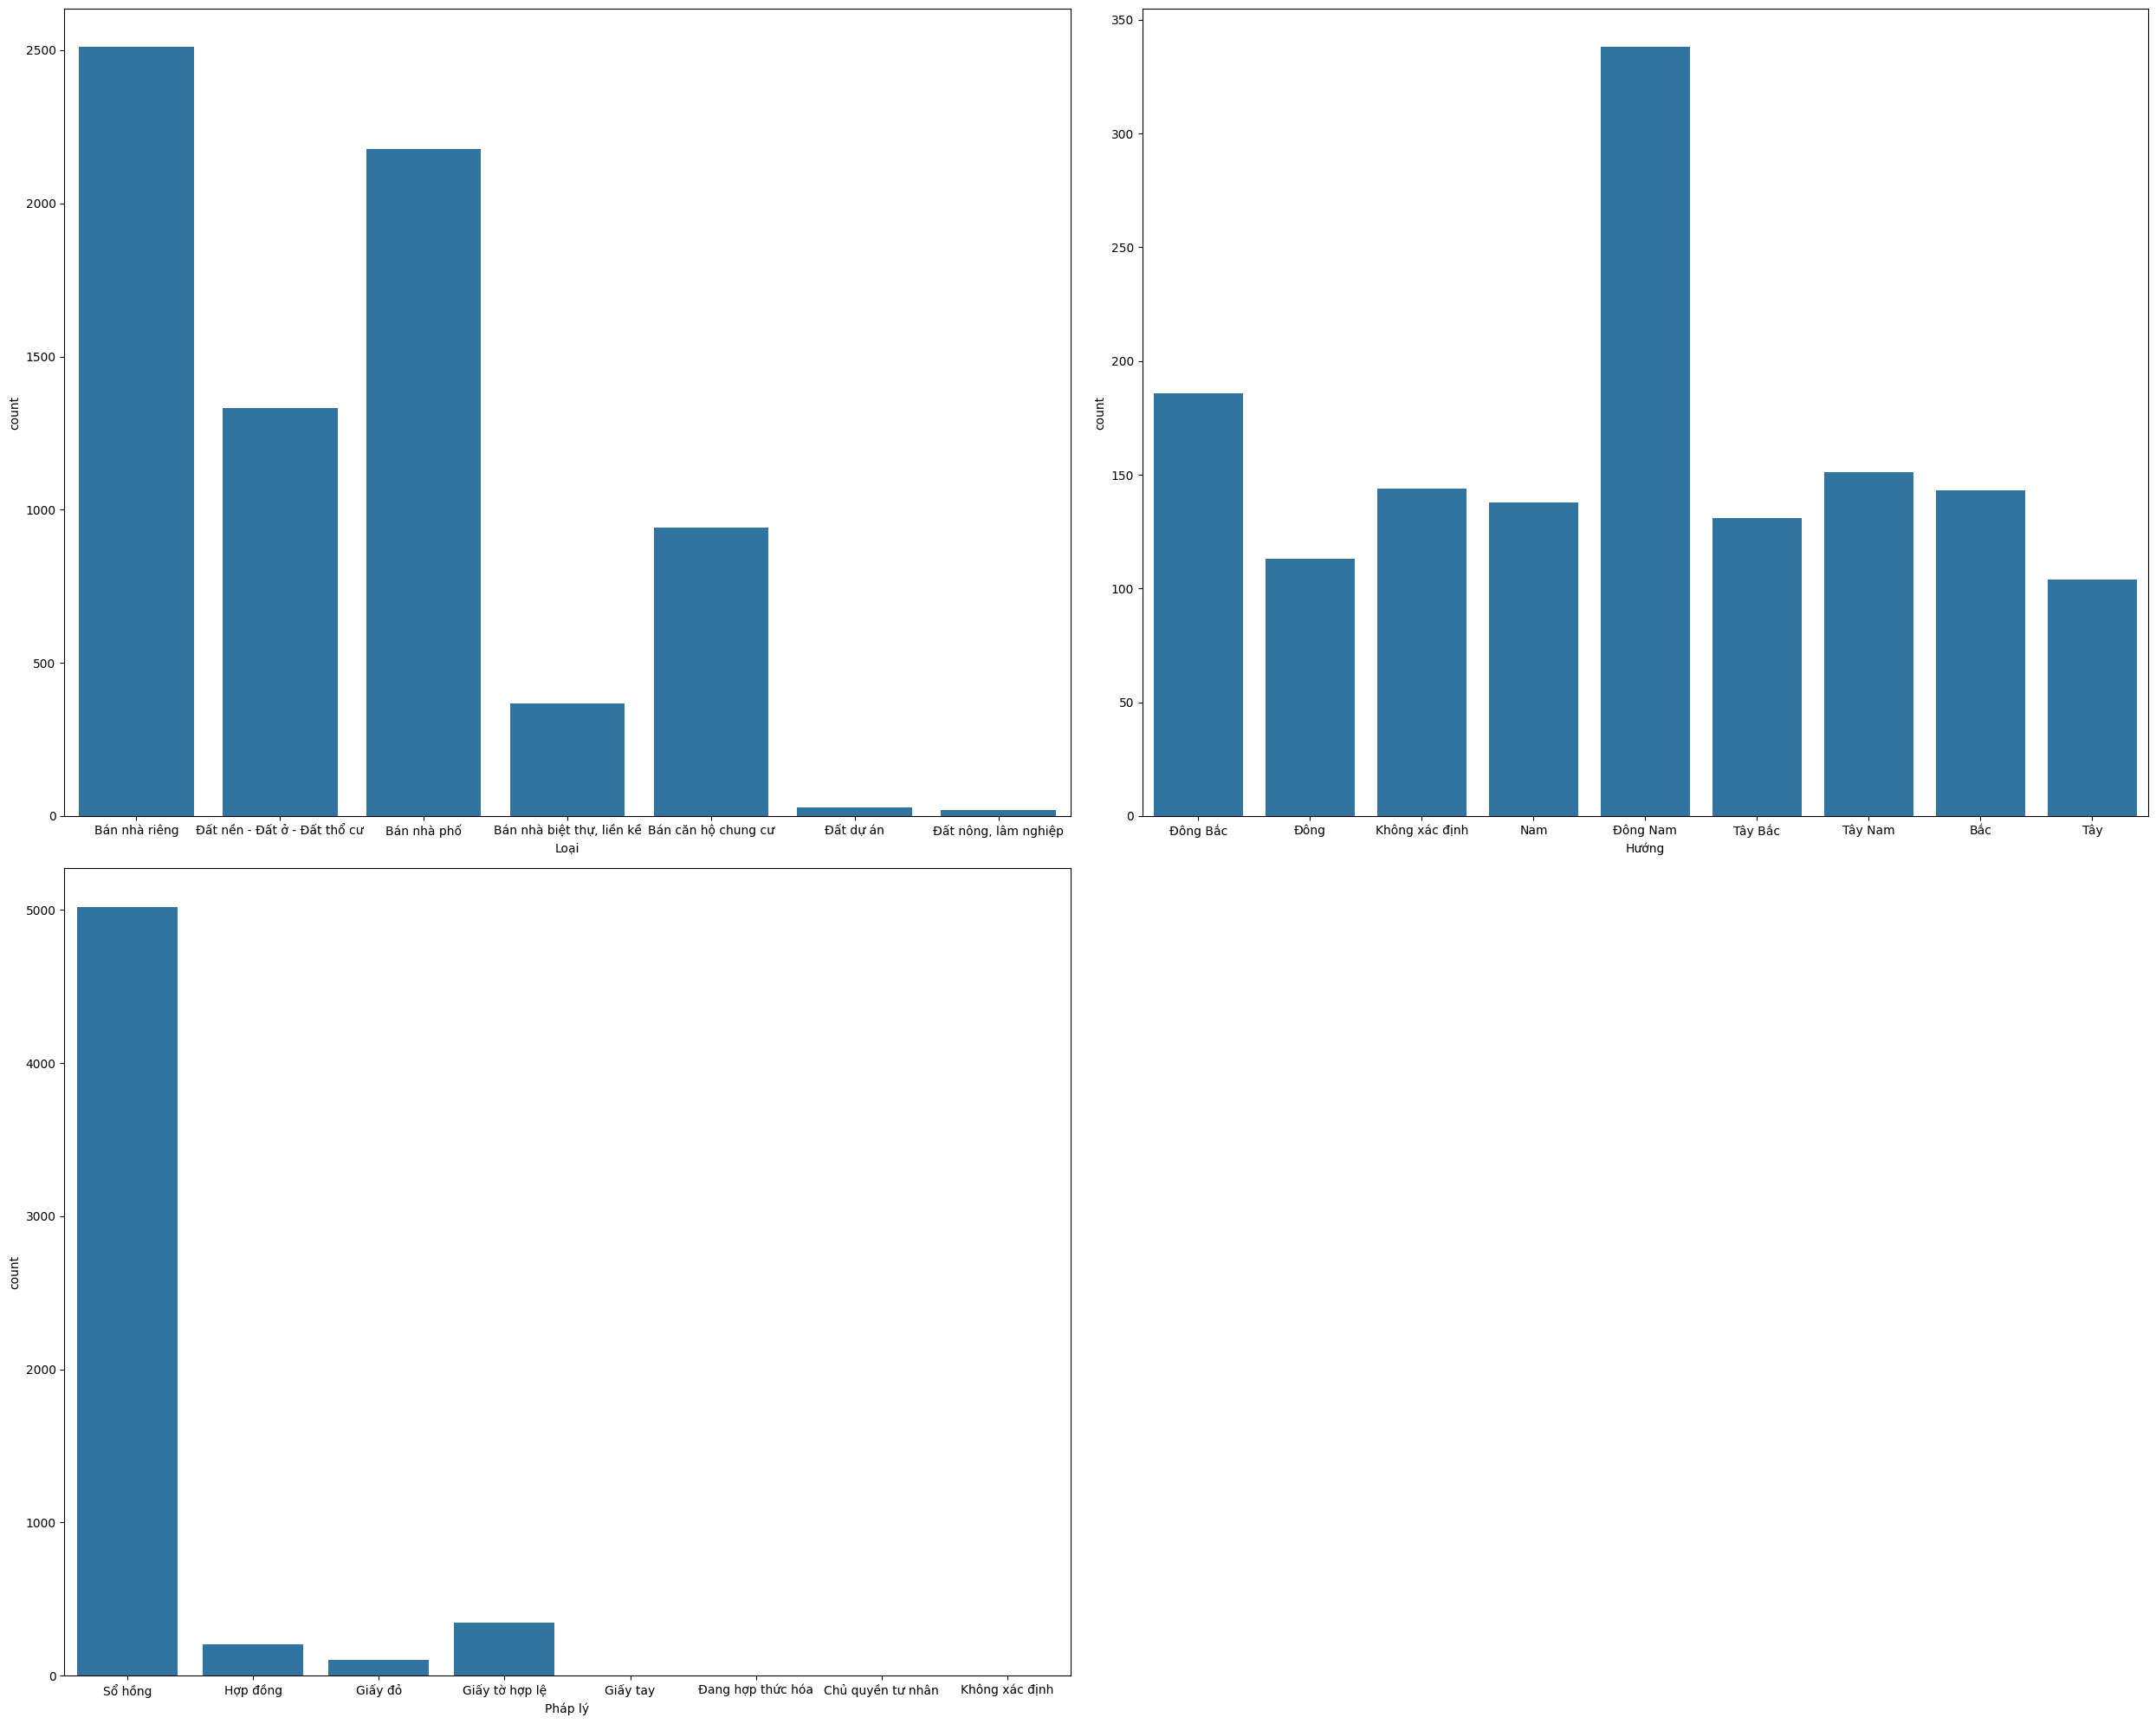

In [ ]:
cate_cols = ['Loại', 'Hướng', 'Pháp lý']
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
fig.delaxes(ax[1][1])
i, j = 0, -1
for col in cate_cols:
  j += 1
  if j > 1:
    i, j = 1, 0
  sns.countplot(x=df[col], ax=ax[i][j])
plt.tight_layout()
plt.show()

In [ ]:
px.box(y=df['Giá'], x=df['Loại'])

Có sự khác nhau đáng kể giữa các Loại bất động sản. Đất nông, lâm nghiệp có giá trung bình thấp nhất và cũng tập trung trong một khoảng rất nhỏ từ 1.4 đến 2.5 tỉ. Tiếp đến là Căn hộ chung cư và Đất nền - Đất ở - Đất thổ cư với giá trung bình khoảng 3 tỉ/BĐS. Đất nền - Đất ở - Đất thổ cư mặc dù giá tập chung trong khoảng Q1 và Q3 cao hơn Căn hộ chung cư (1.65 tỷ đến 8.3 tỷ so với 2 tỷ đến 5 tỷ) nhưng giá trị trung vị của Căn hộ chung cư lại cao hơn (3.3 tỷ so với 2.9 tỷ). Nhà biệt thự, liền kề có giá trị cao nhất với giá trị trung vị là 25 tỷ, tiếp đến là nhà phố với trung vị là 10.5 tỷ. Cả 2 loại bất động sản này đều có những căn nhà lên đến 96 tỷ.

In [ ]:
px.box(y=df['Giá'], x=df['Pháp lý'])

Những bất động sản có giấy tờ uy tín hơn thì giá cũng cao hơn. Những bất động sản có giấy tay và đang hợp thức hóa có giá thấp nhất. Ngược lại, Giấy đỏ và Sổ hồng có giá trị cao nhất.

In [ ]:
px.box(y=df['Giá'], x=df['Hướng'])

Giá trị của bất động sản theo các Hướng khác nhau không có sự khác biệt đáng kể, đây cũng là thuộc tính chứa rất nhiều missing value (>80%) nên cũng không có giá trị phân tích.

-

In [ ]:
px.box(x=df['Quận/Huyện'], y=df['Giá'])

Giá bất động sản cũng có sự khác nhau giữa các Quận/Huyện. Giá nhà cao nhất ở 2 quận trung tâm thành phố là quận 1 và quận 3. Thành phố Thủ Đức (bao gồm quận 2, quận 9 và quận Thủ Đức) là vùng ngoài của Thành phố nhưng lại có giá bất động sản trung bình ngang với các quận trung tâm khác như quận 10, quận 3 và quận 7.

In [ ]:
color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df,
                        lat="Vĩ độ",
                        lon="Kinh độ",
                        hover_data=["Giá"],
                        color="Giá",
                        color_continuous_scale=color_scale,
                        size="Giá",
                        size_max=10,
                        zoom=8,
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Biểu diễn BĐS lên bản đồ VN, mỗi điểm là 1 BĐS và kích thước của điểm là giá của BĐS đó. Có thể thấy những BĐS đắt tiền nhất tập trung ở khu vực Thảo Điền - An Phú - An Khánh và những khu vực xung quanh ga Dân Chủ.  

# Hypothesis Testing

In [ ]:
X_num = df[num_cols]
y_num = df['Giá']
from sklearn.feature_selection import f_regression
F_score, p_value = f_regression(X_num, y_num)

cont_pearson = pd.DataFrame([F_score,p_value], index=['F-score','p-value'], columns=X_num.columns).T
cont_pearson.sort_values(by='p-value')

,F-score,p-value
Diện tích,1770.332722,0.000000e+00
Phòng ngủ,202.496959,2.364101e-45
Toilet,183.381941,2.750332e-41
Phòng khách,28.893181,7.882301e-08
Tầng,18.402060,1.811475e-05
Đường trước nhà,6.012980,1.422404e-02


In [ ]:
df['Pháp lý'].fillna(df['Pháp lý'].mode()[0], inplace=True)

In [ ]:
cate_cols = ['Pháp lý', 'Quận/Huyện']

In [ ]:
from sklearn.feature_selection import f_classif
ANOVA, p_value = zip(*[f_classif(df[['Giá']], df[cols]) for cols in cate_cols])
ANOVA_values = [result[0] for result in ANOVA]
p_value_values = [result[0] for result in p_value]
df_ANOVA = pd.DataFrame({'feaute':cate_cols,"ANOVA":ANOVA_values, "p_value":p_value_values})

In [ ]:
df_ANOVA

,feaute,ANOVA,p_value
0,Pháp lý,5.588724,1.928190e-06
1,Quận/Huyện,83.785991,3.013800e-322


# Xây dựng mô hình học máy

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in cate_cols:
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])
    label_encoders[col] = le

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
from sklearn.model_selection import train_test_split
X = pd.concat([df[num_cols],df[cate_cols]], axis = 1)
y = df['Giá']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
pip install lazypredict -qq

In [ ]:
from lazypredict.Supervised import LazyRegressor

In [ ]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

 79%|███████▊  | 33/42 [00:35<00:06,  1.46it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████| 42/42 [00:42<00:00,  1.01s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 415
[LightGBM] [Info] Number of data points in the train set: 6639, number of used features: 8
[LightGBM] [Info] Start training from score 12.179592


In [ ]:
lazy_models = models
lazy_models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.64,0.64,8.88,0.22
XGBRegressor,0.62,0.63,9.07,1.24
HistGradientBoostingRegressor,0.62,0.62,9.10,0.38
RandomForestRegressor,0.61,0.61,9.20,1.78
BaggingRegressor,0.59,0.59,9.44,0.19
ExtraTreesRegressor,0.58,0.58,9.58,1.33
GradientBoostingRegressor,0.55,0.56,9.86,0.51
KNeighborsRegressor,0.46,0.47,10.79,0.07
DecisionTreeRegressor,0.40,0.41,11.41,0.10


Kết quả cho thấy mô hình LGBM hoạt động tốt nhất khi so sánh ở baseline -> Dùng LGBM để train và tunning

In [ ]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 6639, number of used features: 8
[LightGBM] [Info] Start training from score 12.179592


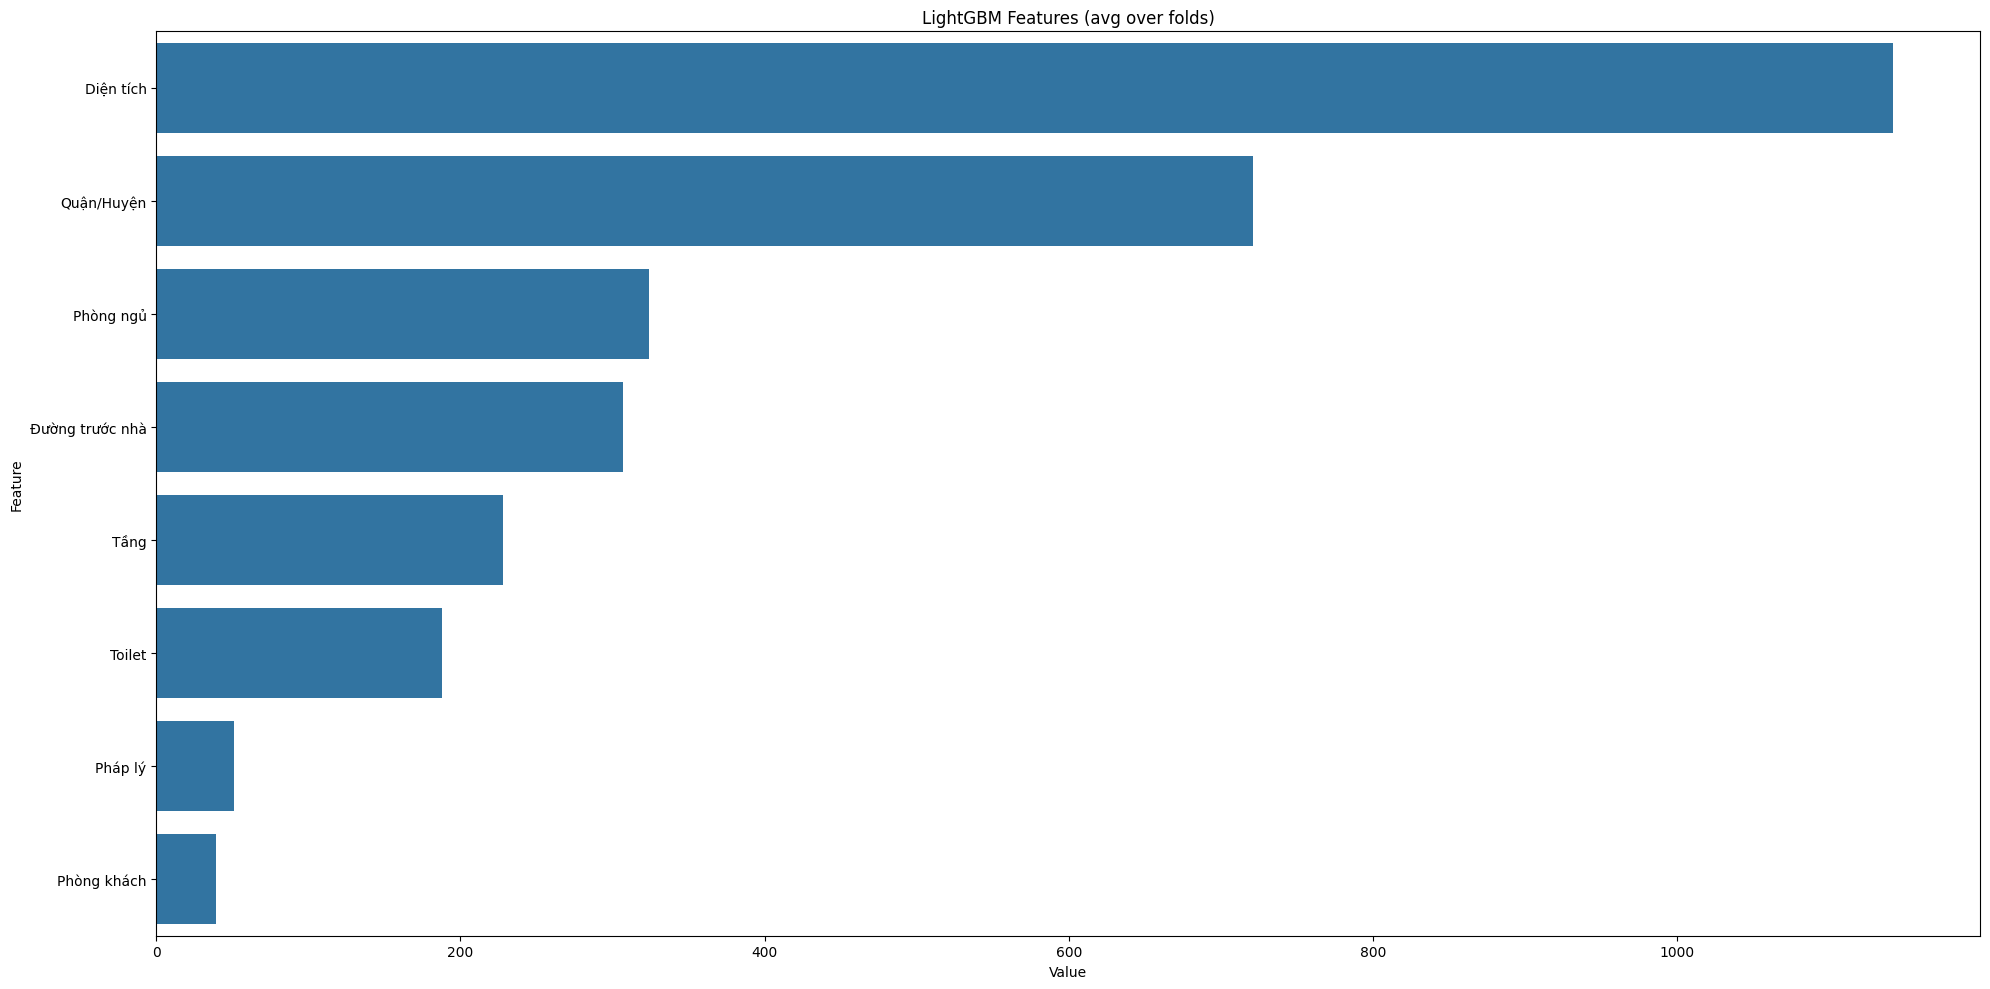

<Figure size 640x480 with 0 Axes>

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

Có những feature có ảnh hưởng rất thấp đến mô hình nên cần phải xem xét loại bỏ những feature này. Điều này có thể làm cho mô hình giảm thời gian tính toán mà không làm giảm độ chính xác của mô hình quá nhiều hoặc đôi khi có thể tăng độ chính xác của mô hình.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

mean_squared_error_list = []
mean_absolute_error_list = []
r2_score_list = []
rm_list = ['Pháp lý','Phòng khách','Toilet','Tầng','Đường trước nhà','Phòng ngủ','Quận/Huyện']
rm_list_current = []
for col in rm_list:
  X_new = X_train.drop(columns = rm_list_current)
  lgbm_new = LGBMRegressor()
  lgbm_new.fit(X_new, y_train)
  y_pred_new = lgbm_new.predict(X_test.drop(columns = rm_list_current))

  mean_squared_error_list.append(mean_squared_error(y_pred_new, y_test))
  mean_absolute_error_list.append(mean_absolute_error(y_pred_new, y_test))
  r2_score_list.append(r2_score(y_pred_new, y_test))
  rm_list_current.append(col)

df_result = pd.DataFrame({"Feature":rm_list,
                          "MSE": mean_squared_error_list,
                          "MAE": mean_absolute_error_list,
                          "R2": r2_score_list
                          })


In [ ]:
df_result

,Feature,MSE,MAE,R2
0,Pháp lý,81.38,4.95,0.41
1,Phòng khách,82.87,4.98,0.40
2,Toilet,82.83,4.99,0.40
3,Tầng,85.09,5.05,0.38
4,Đường trước nhà,85.89,5.12,0.38
5,Phòng ngủ,86.03,5.30,0.34
6,Quận/Huyện,99.75,5.87,0.18


Có 3 thuộc tính sau khi loại bỏ thì hiệu xuất của mô hình không thay đổi quá nhiều là Pháp lý, Phòng khách, Toilet nên 3 thuộc tính này sẽ được loại bỏ để giảm thời gian tính toán của mô hình.

<Axes: >

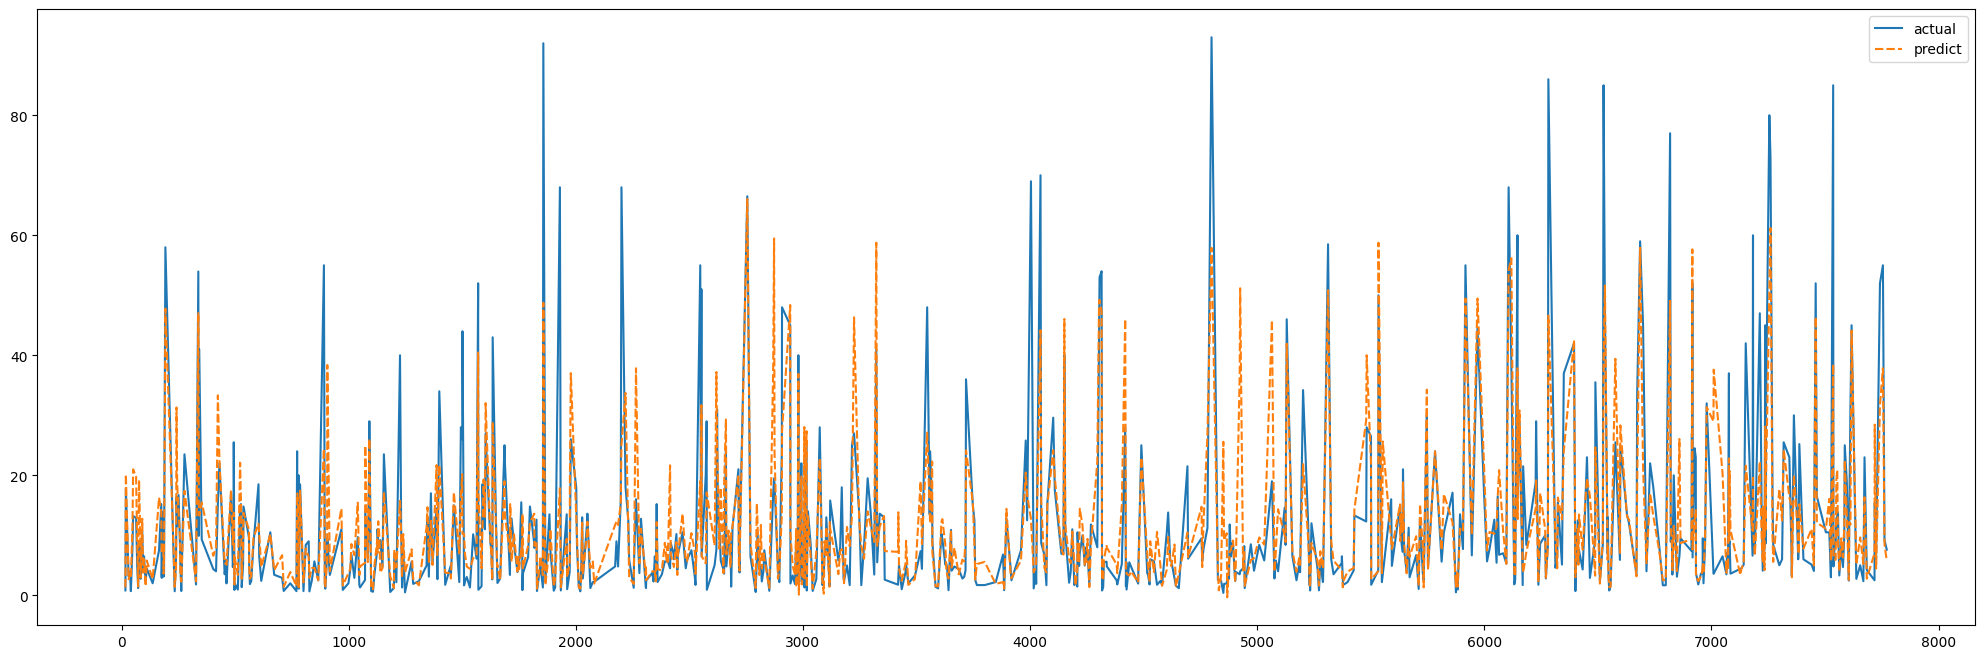

In [ ]:
df_predict = pd.DataFrame({"actual":y_test, "predict":y_pred})
plt.figure(figsize=(25, 8))
sns.lineplot(data=df_predict)

Kết quả dự đoán có cùng hình dạng với giá trị thực tế, tuy nhiên độ chênh lệnh còn khá cao

<Axes: ylabel='error'>

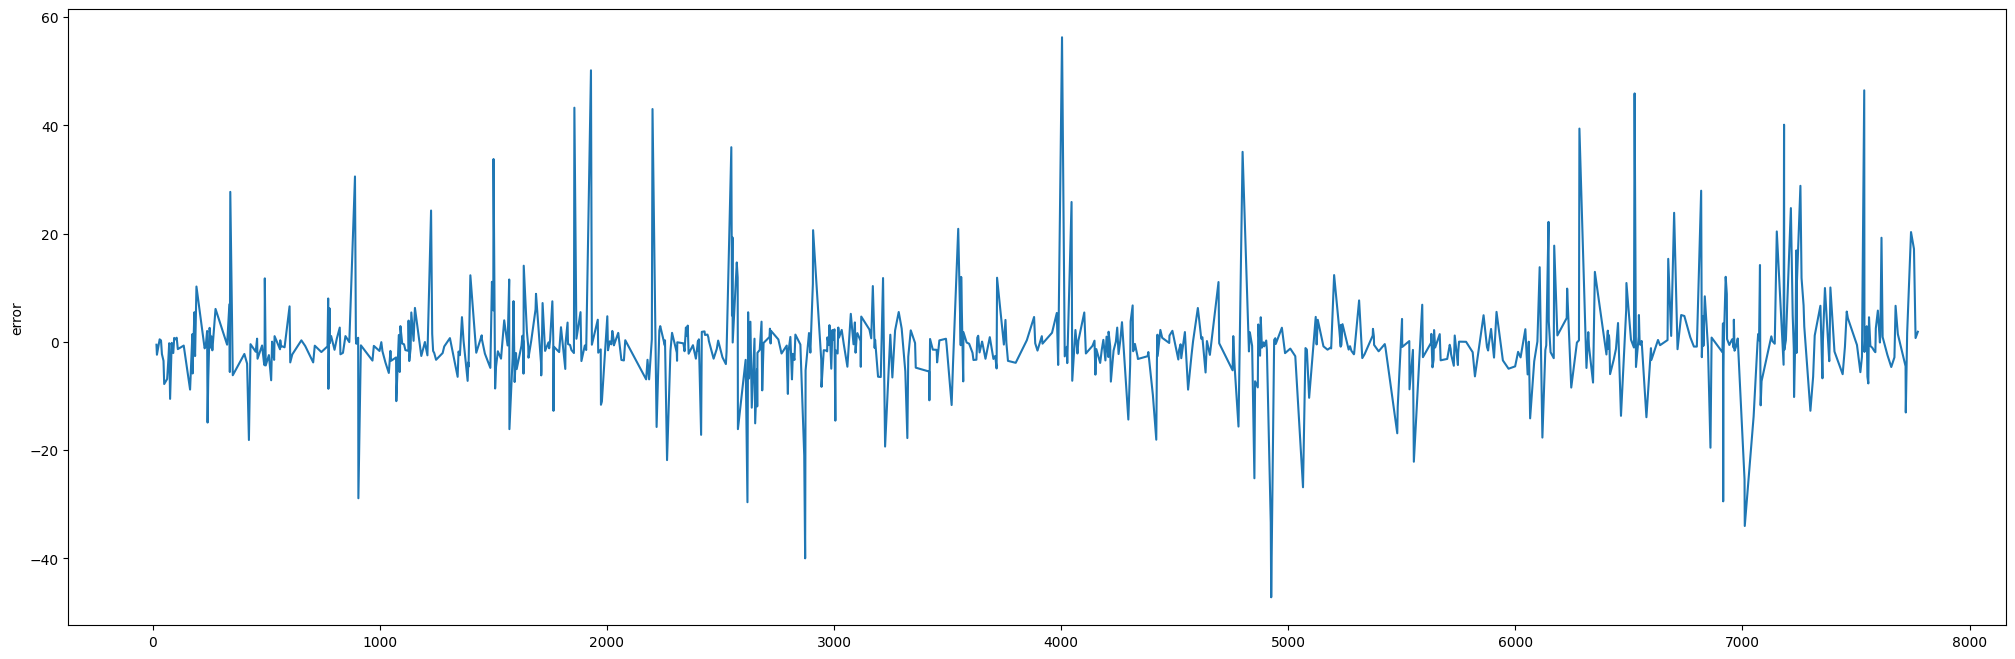

In [ ]:
df_predict['error'] = y_test - y_pred
plt.figure(figsize=(25, 8))
sns.lineplot(data=df_predict['error'])

Kiểm tra xem những dòng dữ liệu bị dự đoán sai nhiều nhất có đặc điểm như thế nào

In [ ]:
df_predict.sort_values(by='error', inplace=True)
df_predict.head()

,actual,predict,error
4925,4.00,51.17,-47.17
2873,19.50,59.48,-39.98
7010,3.60,37.60,-34.00
4923,3.50,36.91,-33.41
2619,7.60,37.21,-29.61


5 dòng có giá thấp nhưng mô hình dự đoan giá cao

In [ ]:
df.loc[df_predict.head().index]

,Giá,Diện tích,Phòng ngủ,Loại,Hướng,Tầng,Toilet,Đường trước nhà,Phòng khách,Pháp lý,Ngày đăng,Mô tả,Căn hộ,Vĩ độ,Kinh độ,Quận/Huyện
4925,4.00,120.00,1,Bán căn hộ chung cư,NaN,1,1,0.00,1,6,12-09-2022,Cần bán căn hộ cao cấp nằm mặt tiền Nguyễn Hữu...,1,10.79,106.69,9
2873,19.50,200.00,1,Bán nhà riêng,NaN,1,1,0.00,1,6,30-09-2022,🤩 NHÀ QUẬN 1 ĐƯỜNG LÊ THỊ RIÊNG - P \r\nBẾN TH...,1,10.78,106.70,5
7010,3.60,500.00,0,Đất nền - Đất ở - Đất thổ cư,NaN,0,0,12.50,0,6,12-08-2022,bán siêu phẩm biệt thự nghỉ dưỡng vị trí đắc đ...,0,10.88,106.73,21
4923,3.50,80.00,1,Bán căn hộ chung cư,NaN,1,1,0.00,1,6,12-09-2022,"Dự án căn hộ mới tại khu Nam Sài Gòn, toạ lạc ...",1,10.78,106.70,5
2619,7.60,250.00,5,Bán nhà phố,Đông Bắc,3,5,12.50,1,6,03-10-2022,Duy nhất chỉ 24 căn độc tôn ( chỉ còn 5 căn du...,1,10.86,106.72,21


In [ ]:
df_predict.tail()

,actual,predict,error
1857,92.00,48.74,43.26
6525,85.00,39.11,45.89
7536,85.00,38.54,46.46
1930,68.00,17.84,50.16
4004,69.00,12.74,56.26


5 dòng có giá cao nhưng mô hình dự đoán thấp

In [ ]:
df.loc[df_predict.tail().index]

,Giá,Diện tích,Phòng ngủ,Loại,Hướng,Tầng,Toilet,Đường trước nhà,Phòng khách,Pháp lý,Ngày đăng,Mô tả,Căn hộ,Vĩ độ,Kinh độ,Quận/Huyện
1857,92.00,140.00,1,Bán nhà phố,NaN,1,1,25.00,1,6,08-10-2022,- Chính chủ bán toà nhà mặt tiền đường Nguyễn ...,1,10.79,106.70,5
6525,85.00,200.00,1,Bán nhà phố,NaN,1,1,0.00,1,6,19-08-2022,"Bán nhà mặt tiền đường Song Hành, phường An Ph...",1,10.80,106.74,21
7536,85.00,744.00,0,Đất nền - Đất ở - Đất thổ cư,NaN,0,0,0.00,0,6,04-08-2022,BDS Hùng Vĩ Land [NC] Gía 85 tỉ ~ 1154 tr/m² l...,0,10.79,106.75,21
1930,68.00,234.00,1,Bán nhà phố,NaN,1,1,12.50,1,6,14-10-2022,"Mặt tiền đường Quốc Hương, phường Thảo Điền\r\...",1,10.88,106.66,8
4004,69.00,350.00,0,Đất nền - Đất ở - Đất thổ cư,NaN,1,0,17.50,0,6,21-09-2022,Chính chủ cần chuyển nhượng lại khuôn đất góc ...,0,10.88,106.66,8
